In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import PIL
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.vlc import VLC
from utils.path_utils import Files
from evaluation.config import *
from evaluation.analysis import Plotter
from tkinter import filedialog

%matplotlib qt
pd.options.display.max_columns = 30

KeyboardInterrupt: 

ImportError: numpy.core.multiarray failed to import

# Analysis

## VLC

In [ ]:
directory = "D:\\Guy_Gilad\\Exp1_GuyGilad\\raw"
files = Files(directory, extension='Bmp', sorting_key=lambda f: int(f.split('-')[-1].split('.')[0]))
timing_config = TimingConfig.load_json("D:\\Guy_Gilad\\Bio-Proj\\logs\\time_config.json")
# log_path = "/Users/guycohen/Desktop/Bio-Project/eval/bboxes2.csv"
# log_path = "/Users/guycohen/Desktop/Bio-Project/Optimal/bboxes.csv"
# log_path = "D:\\Guy_Gilad\\Exp2_GuyGilad\\logs_yolo\\bboxes.csv"
log_path = "data/Data/Exp1_GuyGilad_logs_yolo/bboxes.csv"


In [ ]:
log_path = "data/Data/Exp1_GuyGilad_logs_yolo/bboxes.csv"
experiment_config = ExperimentConfig.load_json("data/Data/Exp1_GuyGilad_logs_yolo/experiment_config.json")

time_config = TimingConfig(
    imaging_time_ms=100,
    pred_time_ms=15,
    moving_time_ms=50,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.22, 0.22),
    experiment_config=experiment_config,
)
vlc = VLC(None, time_config, log_path, 'mic')

In [ ]:
import cProfile
vlc = VLC(files, timing_config, log_path, 'plt')
vlc.print_hotkeys()
vlc.streamer.update_trakbar("delay", 1)
vlc.show_cam = True
vlc.show_micro = True
vlc.show_pred = True
vlc.play = True
vlc.mainloop()
# cProfile.run('vlc.mainloop()')


In [ ]:
vlc = VLC(files, timing_config, log_path, 'mic')
vlc.print_hotkeys()
vlc.mainloop()

## Plots

In [ ]:
def cond(df: pd.DataFrame, threshold: float=1.5) -> pd.DataFrame:
    mask1 = (df['cycle_step'] == 14) & (df['worm_center_dist'] > threshold)
    cycles = df[mask1]['cycle'].unique()
    return df['cycle'].isin(cycles)

def cond_imaging(df:pd.DataFrame) -> pd.DataFrame:
    return df['phase'] == 'imaging'

def rolling_avg(data, col, window_size=5):
    data[col+'_avg'] = Plotter.rolling_average(data, window_size=window_size, column=col)
    return data

In [ ]:

# original_log_path = "/Users/guycohen/Desktop/Bio-Project/eval/bboxes2.csv"
# log_path = "/Users/guycohen/Desktop/Bio-Project/eval_corrected_movement/bboxes.csv"
# log_path = "/Users/guycohen/Desktop/Bio-Project/Optimal/bboxes.csv"
# log_path = "/Users/guycohen/Desktop/Bio-Project/Controller2/bboxes.csv"
log_path = "/Users/guycohen/Desktop/Bio-Project/PolyfitControllerV2/bboxes.csv"
# log_path = "/Users/guycohen/Desktop/Bio-Project/test1/bboxes.csv"
timing_config = TimingConfig.load_json("/Users/guycohen/Desktop/Bio-Project/time_config.json")

pltr = Plotter(log_path, timing_config)
# pltr_orig = Plotter(original_log_path, timing_config)

In [ ]:
data = pltr.print_statistics(n=10)
# data_orig = pltr_orig.print_statistics()

In [ ]:
(data['mic_center_x'] - data['wrm_center_x']).hist(bins=15)

In [ ]:
sns.scatterplot(data=data, x='frame', y='worm_deviation', hue='wrm_speed')

In [ ]:
def plot_histogram(pltr, x_col:str, n:int=1, hue=None, condition=None, **kwargs):
    data = pltr.data_prep_frames(n=n)
    
    if condition is not None:
            data = data[condition(data)]
    fig, ax = plt.subplots()
    sns.histplot(data=data, x=x_col, hue=hue,stat='density', **kwargs)

def plot_jointplot(pltr, x_col:str, y_col:str, n:int=1, kind:str='scatter', hue=None, condition=None, transform=None, **kwargs):
    data = pltr.data_prep_frames(n=n)
    
    if transform is not None:
        data = transform(data)
        
    if condition is not None:
            data = data[condition(data)]
    
    sns.jointplot(data=data, x=x_col, y=y_col, hue=hue, kind=kind, **kwargs)

# plot_histogram(pltr, 'worm_deviation', n=15, hue='worm_deviation')

In [ ]:
plot_jointplot(pltr, 'wrm_speed', 'worm_deviation', n=5, kind='scatter')

In [ ]:
plot_jointplot(pltr, x_col='wrm_speed_x', y_col='wrm_speed_y', n=5, kind='scatter', hue='worm_angle_avg', transform=lambda data: rolling_avg(data, 'worm_angle', window_size=5))

In [ ]:
plot_histogram(pltr, x_col='bbox_area_diff', condition=lambda df: df['bbox_area_diff'] > 1e-3)

In [ ]:
def avg_speed(data:pd.DataFrame, n_list:list[int]=[10]) -> np.ndarray:
    data = data.copy()
    
    wrm_speed_x = np.zeros(len(data['frame']))
    wrm_speed_y = np.zeros(len(data['frame']))
    for n in n_list:
        wrm_speed_x += data["wrm_center_x"].diff(n) / len(n_list)
        wrm_speed_y += data["wrm_center_y"].diff(n) / len(n_list)
        # avgs.append(Plotter.worm_angle(data, n=n))
    # mean of all averages
    data['wrm_speed_x_avg'] = wrm_speed_x
    data['wrm_speed_y_avg'] = wrm_speed_y
    return data

def worm_angle(data:pd.DataFrame, n:int=15) -> np.ndarray:
    data = data.copy()

    wrm_speed_x = data["wrm_center_x"].diff(n) / n
    wrm_speed_y = data["wrm_center_y"].diff(n) / n
    angle_speed = np.arctan2(wrm_speed_y, wrm_speed_x)

    min_h, min_w = np.min(data["wrm_h"]), np.min(data["wrm_w"])
    x_sign = np.sign(data["wrm_center_x"].diff(3))
    y_sign = np.sign(data["wrm_center_y"].diff(3))
    # data['wrm_speed_x_avg'] = (data['wrm_w']-min_w)*x_sign
    # data['wrm_speed_y_avg'] = (data['wrm_h']-min_h)*y_sign
    angle = np.arctan2((data['wrm_h']-min_h)*y_sign, (data['wrm_w']-min_w)*x_sign)

    angle_diff = np.abs(angle - angle_speed) / (2*np.pi)
    data['wrm_speed_x_avg'] = wrm_speed_x * (1-angle_diff)
    data['wrm_speed_y_avg'] = wrm_speed_y * (1-angle_diff)
    return data

In [ ]:
def plot_flow(pltr, x_col:str, y_col:str, n:int=1, kind:str='scatter', hue=None, condition=None, transform=None, **kwargs):
    data = pltr.data_prep_frames(n=n)
    
    if transform is not None:
        data = transform(data)
        
    if condition is not None:
            data = data[condition(data)]
    
    # cmap = sns.color_palette("husl", as_cmap=True, n_colors=len(data['frame']))
    fig, ax = plt.subplots()
    plt.quiver(data[x_col], data[y_col], data['wrm_speed_x_avg'], data['wrm_speed_y_avg'], np.linspace(0,1,len(data['frame'])), **kwargs)
    ax.invert_yaxis()
    ax.grid()


# plot_flow(pltr, x_col='wrm_center_x', y_col='wrm_center_y', n=15, angles='xy', transform=lambda data: rolling_avg(data, 'worm_angle', window_size=1))
plot_flow(pltr, x_col='wrm_center_x', y_col='wrm_center_y', n=5, angles='xy', scale_units='xy', scale=1,
          transform=lambda df: worm_angle(df, 15), 
        #   condition=lambda df: df['cycle_step'] == 9,
          )

In [ ]:
# cols = ['frame', 'cycle', 'plt_x', 'plt_y', 'cam_x', 'cam_y', 'cam_w',
#        'cam_h', 'mic_x', 'mic_y', 'mic_w', 'mic_h', 'wrm_x', 'wrm_y', 'wrm_w',
#        'wrm_h', 'wrm_center_x', 'wrm_center_y', 'mic_center_x', 'mic_center_y',
#        'wrm_speed', 'bbox_area_diff', 'bbox_edge_diff']


# (data[cols] - data_orig[cols]).describe()

In [ ]:
pltr.plot_area_vs_speed()

In [ ]:
data.columns

In [ ]:

pltr.plot_2d_deviation(n=2, hue='cycle_step')

In [ ]:
pltr.plot_deviation()

In [ ]:
pltr.plot_area_vs_speed_guy(n=1, window_size=1, hue='phase')

In [ ]:
pltr.plot_cycle_step_vs_speed()

In [ ]:
pltr.plot_trajectory(n=15, hue='wrm_speed')

In [ ]:
def plot_speed_vs_time(pltr, n: int = 1, window_size: int = 15, hue=None, condition=None) -> plt.Figure:
        data = pltr.data_prep_frames(n=n)
        data["wrm_speed_avg"] = Plotter.rolling_average(data, window_size=window_size, column="wrm_speed")
        fig, ax = plt.subplots()
        if condition is not None:
            mask = condition(data) & mask
        g = sns.histplot(data=data, x="wrm_speed", ax=ax, hue=hue)
        g.figure.suptitle(f"n = {n}, rolling window = {window_size}")
        return g.figure

In [ ]:
plot_speed_vs_time(pltr, n=15, window_size=1, hue='phase')

In [ ]:
timing_config.mm_per_px / timing_config.ms_per_frame

In [ ]:
def plot_2d_deviation_with_angle(pltr, n:int=1, hue="cycle_step", condition=None) -> plt.Figure:
        data = pltr.data_prep_frames(n=n)
        data["worm_center_dist_x"] = data["wrm_center_x"] - data["mic_center_x"]
        data["worm_center_dist_y"] = data["wrm_center_y"] - data["mic_center_y"]

        data["cycle_step"] = data["frame"] % pltr.timing_config.cycle_length
        min_h, min_w = np.min(data["wrm_h"]), np.min(data["wrm_w"])
        x_sign = np.sign(data["wrm_center_x"].diff(n))
        y_sign = np.sign(data["wrm_center_y"].diff(n))
        data['angle'] = np.arctan2((data['wrm_h']-min_h)*y_sign, (data['wrm_w']-min_w)*x_sign)
        if condition is not None:
            data = data[condition(data)]
        
        # display(data.head(50))
        # g = sns.histplot(data=data, x="angle")
        g = sns.jointplot(data=data, x="wrm_speed", y="angle", kind="scatter", hue=hue, alpha=0.6)
        # g = sns.jointplot(data=data, x="worm_center_dist_x", y="worm_center_dist_y", kind="scatter", hue=hue, alpha=0.6)
        # g.set_axis_labels("distance x", "distance y")
        # g.figure.suptitle(f"distance between worm and microscope centers in each axis")

        return g.figure

In [ ]:
plot_2d_deviation_with_angle(pltr, 5, hue=None, condition=lambda df: df['wrm_speed'] > -0.3)

In [ ]:
def plot_area_vs_time(pltr:Plotter, n: int = 1, window_size: int = 15, hue=None, condition=None) -> plt.Figure:
        data = pltr.data_prep_frames(n=n)
        data["wrm_speed_avg"] = Plotter.rolling_average(data, window_size=window_size, column="wrm_speed")
        data["worm_center_dist"] = np.sqrt(
            (data["wrm_center_x"] - data["mic_center_x"]) ** 2 + (data["wrm_center_y"] - data["mic_center_y"]) ** 2
        )
        data["cycle_step"] = data["frame"] % pltr.timing_config.cycle_length
        data['angle'] = np.arctan2(data['wrm_w'], data['wrm_h'])
        # fig, ax = plt.subplots()
        mask = data["bbox_area_diff"] > 1e-3
        if condition is not None:
            mask = condition(data) & mask
        g = sns.jointplot(
            data=data[mask], x="wrm_speed_avg", y="worm_center_dist", hue=hue, kind="scatter", dropna=True)
        g.figure.suptitle(f"n = {n}, rolling window = {window_size}")
        return g.figure

In [ ]:
plot_area_vs_time(pltr, n=18, window_size=1, hue='angle')

In [ ]:
raise Exception("Finished")

# Run Simulation

In [1]:
from evaluation.simulator import *
from evaluation.sim_controllers import *
from evaluation.config import ExperimentConfig
from frame_reader import DummyReader
from evaluation.motor_controllers import *

# base_path = "/Users/guycohen/Desktop/Bio-Project/"
base_path = f"data/Data/Exp1_GuyGilad_logs_yolo/"


## Run CSV Simulation

In [2]:
exp_base_path = "logs"

# time_config = TimingConfig.load_json(base_path + "time_config.json")
# time_config = TimingConfig.load_json(base_path + "time_config_medium_micro.json")
experiment_config = ExperimentConfig.load_json(f"{base_path}/experiment_config.json")
log_config = LogConfig(
    root_folder=exp_base_path,
    save_mic_view=False,
    save_cam_view=False,
    save_err_view=False,
)

In [3]:
time_config = TimingConfig(
    imaging_time_ms=200,
    pred_time_ms=40,
    moving_time_ms=50,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.32, 0.32),
    experiment_config=experiment_config,
)

In [4]:
from evaluation.sim_controllers.guys_controllers import *
from evaluation.sim_controllers.csv_controller import CsvController
from evaluation.sim_controllers.optimal_controller import  OptimalController
from evaluation.sim_controllers.polyfit_controller import PolyfitController
import torch

log_path = base_path + "bboxes.csv"

# controller = CsvController(time_config, "/Users/guycohen/Desktop/Bio-Project/eval_corrected_movement/bboxes.csv")

# controller = TestController1(time_config, "/Users/guycohen/Desktop/Bio-Project/eval/bboxes.csv")
# controller = Controller2(time_config, "/Users/guycohen/Desktop/Bio-Project/eval_corrected_movement/bboxes.csv")
# controller = OptimalController(time_config, "/Users/guycohen/Desktop/Bio-Project/eval_corrected_movement/bboxes.csv")

model = torch.load("data/RecurrentMLP4.pt")
print(model)
controller = MLPController(time_config, log_path, model)

weights = np.ones(11)
# weights = np.asanyarray([0.0477, 0.0002, 0. ,    0.0007, 0.0057, 0.042 , 0.1558, 0.6245 ,0.7627])
sample_frames = np.asanyarray(
    [
        0,
        5,
        9,
        -time_config.cycle_length + 0,
        -time_config.cycle_length + 5,
        -time_config.cycle_length + 9,
        -2 * time_config.cycle_length + 0,
        -2 * time_config.cycle_length + 5,
        -2 * time_config.cycle_length + 9,
        -3 * time_config.cycle_length + 9,
        -4 * time_config.cycle_length + 9,
    ]
)
# controller = PolyfitController(time_config, log_path, degree=2, weights=weights, sample_times=sample_frames)







RMLP(
  (input): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (blocks): ModuleList(
    (0-1): 2 x MlpBlock(
      (sequence): Sequential(
        (0): Linear(in_features=40, out_features=10, bias=True)
        (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=10, out_features=4, bias=True)
        (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=4, out_features=10, bias=True)
        (7): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=10, out_features=40, bias=True)
        (10): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      )
    )
  

In [5]:

logging_controller = LoggingController(controller, log_config)
motor_controller = SineMotorController(time_config)
# motor_controller = SimpleMovementController(time_config, 0)

sim = Simulator(time_config, experiment_config, logging_controller, reader=None, motor_controller=motor_controller)

In [6]:
sim.run()
time_config.save_json(exp_base_path + "/time_config.json")
experiment_config.save_json(exp_base_path + "/exp_config.json")

Simulation Progress:   0%|          | 0/4333 [00:00<?, ?cycle/s]

<class 'evaluation.config.TimingConfig'>
<class 'evaluation.config.ExperimentConfig'>


In [7]:
from evaluation.analysis import Plotter

pltr = Plotter(log_config.bbox_file_path, time_config)
data = pltr.print_statistics(n=10)

##################### No Preds #####################
Num of No Preds: 571
No prediction in frames: [6152, 6154, 6155, 6162, 6211, 6220, 16219, 18420, 18421, 18422, 18424, 18425, 18427, 18428, 18429, 18430, 18431, 18432, 18433, 18434, 18435, 18436, 18437, 18438, 18439, 18440, 18447, 18478, 18479, 18480, 18481, 18482, 18483, 18484, 18485, 18486, 18487, 18488, 18489, 18490, 18491, 18492, 18493, 18494, 18495, 18496, 18497, 18498, 18499, 18500, 18501, 18502, 18503, 18504, 18505, 18506, 18507, 18508, 18509, 18510, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18522, 18523, 18524, 18525, 18526, 18527, 18528, 18529, 18530, 18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539, 18540, 18541, 18542, 18543, 18544, 18545, 18546, 18547, 18548, 18549, 18550, 18551, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18568, 18569, 18570, 18571, 18572, 18573, 18574, 18575, 18576, 18577, 18578, 18579, 185

,frame,cycle,plt_x,plt_y,cam_x,cam_y,cam_w,cam_h,mic_x,mic_y,...,mic_center_y,wrm_speed,wrm_speed_x,wrm_speed_y,bbox_area_diff,bbox_edge_diff,worm_angle,worm_deviation_x,worm_deviation_y,worm_deviation
count,64409.000000,64409.00000,64409.000000,64409.000000,64409.000000,64409.000000,64409.0,64409.0,64409.000000,64409.000000,...,64409.000000,64409.000000,64409.000000,64409.000000,6.440900e+04,64409.000000,64409.000000,64409.000000,64409.000000,64409.000000
mean,32527.754615,2168.05021,988.895884,853.749818,808.895884,673.749818,360.0,360.0,974.895884,839.749818,...,854.249818,0.543053,0.007065,-0.000235,8.134865e-03,0.131526,-0.101054,-0.635450,-0.507721,3.181013
std,18772.528211,1251.50192,438.542798,444.027941,438.542798,444.027941,0.0,0.0,438.542798,444.027941,...,444.027941,0.282492,0.410645,0.453910,5.626022e-02,0.981962,1.797777,2.605953,2.891535,2.386325
min,15.000000,1.00000,213.000000,183.000000,33.000000,3.000000,360.0,360.0,199.000000,169.000000,...,183.500000,0.000309,-3.703702,-4.066475,-2.464808e-14,0.000000,-3.123347,-26.466484,-40.858170,0.002450
25%,16123.000000,1074.00000,642.000000,456.000000,462.000000,276.000000,360.0,360.0,628.000000,442.000000,...,456.500000,0.380227,-0.289573,-0.345325,-3.525838e-15,0.000000,-1.738769,-2.075958,-2.064644,1.640109
50%,32615.000000,2174.00000,1078.000000,829.000000,898.000000,649.000000,360.0,360.0,1064.000000,815.000000,...,829.500000,0.551446,-0.006676,-0.025987,3.738506e-16,0.000000,-0.168264,-0.619835,-0.484535,2.695756
75%,48717.000000,3247.00000,1323.000000,1312.000000,1143.000000,1132.000000,360.0,360.0,1309.000000,1298.000000,...,1312.500000,0.692869,0.312562,0.336564,4.745208e-15,0.000000,1.437386,0.791512,1.030998,4.071142
max,64994.000000,4332.00000,1673.000000,1530.000000,1493.000000,1350.000000,360.0,360.0,1659.000000,1516.000000,...,1530.500000,4.080179,2.106039,4.038630,1.000000e+00,33.753311,3.141593,23.503151,21.018387,40.899145


In [8]:
def bbox_eval(pltr:Plotter, df:pd.DataFrame) -> pd.DataFrame:
    data = pltr.data_prep_frames(n=10)
    grouped_data = data.groupby("cycle")
    avg_speed = grouped_data["wrm_speed"].mean()

    data = Plotter.remove_phase(data, "moving")

    max_area_diff = data.groupby("cycle")["bbox_area_diff"].max()

    data = pd.DataFrame({"wrm_speed": avg_speed, "bbox_area_diff": max_area_diff})
    return data

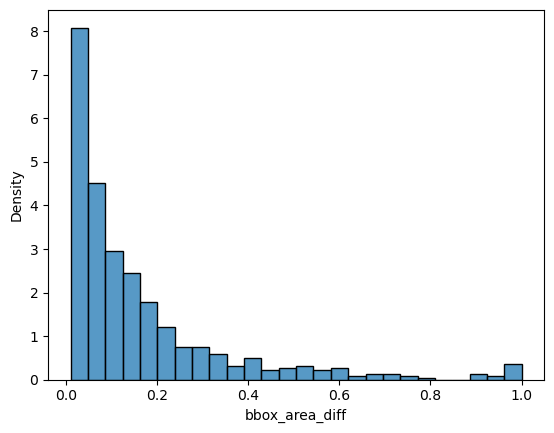

In [9]:
pltr.plot_histogram('bbox_area_diff', n=10, stat='density', transform=lambda df: bbox_eval(pltr, df), condition=lambda df: df['bbox_area_diff'] > 1e-2)

Correlation Coefficient: nan** On entry to DGELSD, parameter number  6 had an illegal value

Correlation Slope: 0.00


,wrm_speed,bbox_area_diff
count,4306.000000,4305.000000
mean,0.630694,0.022235
std,0.291931,0.090468
min,0.013940,0.000000
5%,0.267260,0.000000
10%,0.342590,0.000000
15%,0.397035,0.000000
20%,0.446950,0.000000
25%,0.481262,0.000000
30%,0.515865,0.000000


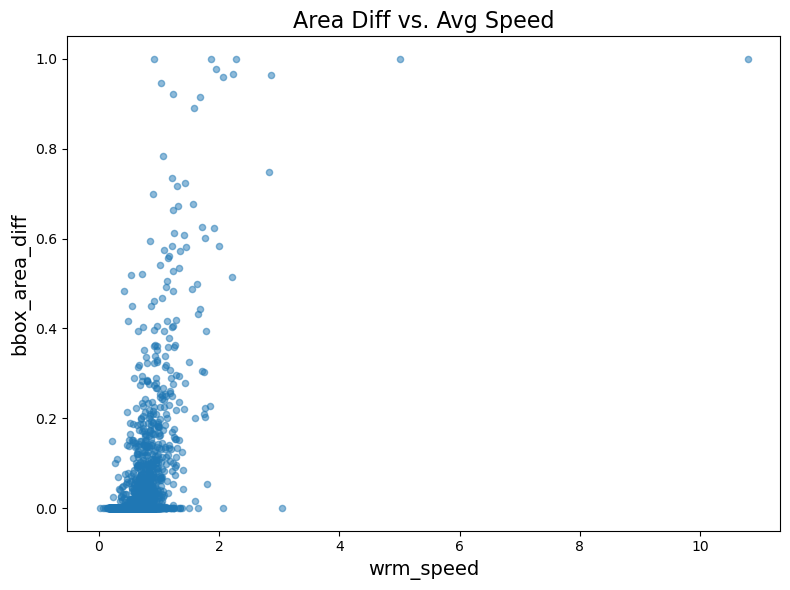

In [10]:
pltr.plot_area_vs_speed()

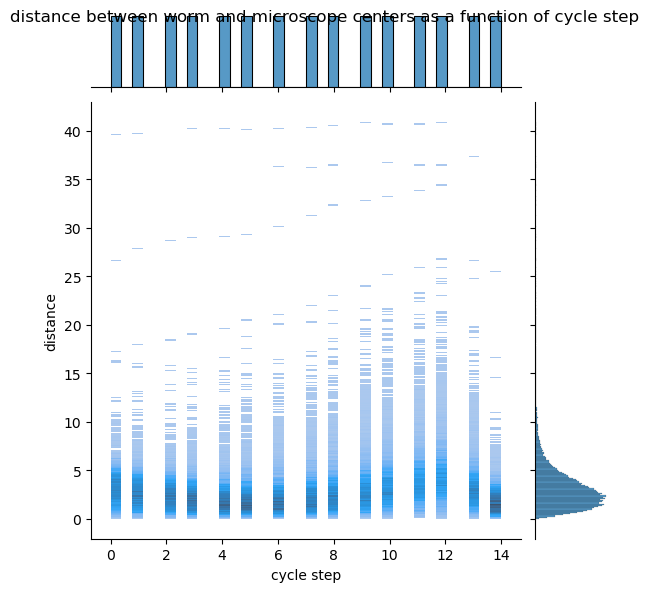

In [11]:
_ = pltr.plot_deviation()

In [ ]:
raise Exception("Finished")

## Real Simulation

In [ ]:
print(time_config.imaging_frame_num + time_config.moving_frame_num)

In [ ]:

controller = LoggingController(time_config, yolo_config, log_config)
#controller = YoloController(time_config, yolo_config)
sim = Simulator(time_config, reader, controller)

In [ ]:
sim.run()

In [ ]:
cv.destroyAllWindows()
raise Exception("Finished")